In [4]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
# from tensorflow.keras.layers.core import *
# from tensorflow.keras.layers.convolutional import *
from tensorflow.keras import backend as K
import tensorflow.compat.v1 as tf

# Initialize the setting

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [62]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16
        self.data_dir = '..\\data\\SHREC\\'
C = Config()

# Building the model

In [57]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H,W],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,22*3))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),22*3))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)

    print("slow", diff_slow)
    print("fast", diff_fast)
    print("M", M)
    print("P", P)

    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [58]:
def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.3)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [59]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters)

slow Tensor("reshape_32/Identity:0", shape=(None, 32, 66), dtype=float32)
fast Tensor("reshape_33/Identity:0", shape=(None, 16, 66), dtype=float32)
M Tensor("input_37:0", shape=(None, 32, 231), dtype=float32)
P Tensor("input_38:0", shape=(None, 32, 22, 3), dtype=float32)


In [60]:
DD_Net.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  [(None, 32, 231)]    0                                            
__________________________________________________________________________________________________
P (InputLayer)                  [(None, 32, 22, 3)]  0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 4, 128)       119392      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 128)          0           model_4[1][0]              

## load data

In [65]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

## Without frame_sampling train

In [66]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

100%|██████████████████████████████████████████████████████████████████████████████| 1960/1960 [00:26<00:00, 74.61it/s]


In [68]:
print(X_0.shape, X_1.shape, Y.shape)

(1960, 32, 231) (1960, 32, 22, 3) (1960, 14)


In [69]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|████████████████████████████████████████████████████████████████████████████████| 840/840 [00:11<00:00, 75.48it/s]


In [70]:
print(X_test_0.shape, X_test_1.shape, Y_test.shape)

(840, 32, 231) (840, 32, 22, 3) (840, 14)


In [87]:
import tensorflow.keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 14s 7ms/sample - loss: 0.1597 - accuracy: 0.9536 - val_loss: 0.9058 - val_accuracy: 0.7524
Epoch 2/600
1960/1960 [==============================] - 2s 796us/sample - loss: 0.1648 - accuracy: 0.9561 - val_loss: 0.8754 - val_accuracy: 0.7619
Epoch 3/600
1960/1960 [==============================] - 2s 798us/sample - loss: 0.1617 - accuracy: 0.9592 - val_loss: 0.8560 - val_accuracy: 0.7476
Epoch 4/600
1960/1960 [==============================] - 2s 810us/sample - loss: 0.1687 - accuracy: 0.9571 - val_loss: 0.8811 - val_accuracy: 0.7393
Epoch 5/600
1960/1960 [==============================] - 2s 791us/sample - loss: 0.1559 - accuracy: 0.9571 - val_loss: 0.9135 - val_accuracy: 0.7393
Epoch 6/600
1960/1960 [==============================] - 2s 821us/sample - loss: 0.1746 - accuracy: 0.9505 - val_loss: 0.9880 - val_accuracy: 0.7274
Epoch 7/600
1960/1960 [==============================] - 2s 

Epoch 56/600
1960/1960 [==============================] - 2s 808us/sample - loss: 0.0924 - accuracy: 0.9724 - val_loss: 0.6633 - val_accuracy: 0.8202
Epoch 57/600
1960/1960 [==============================] - 2s 833us/sample - loss: 0.0954 - accuracy: 0.9745 - val_loss: 0.6547 - val_accuracy: 0.8238
Epoch 58/600
1960/1960 [==============================] - 2s 981us/sample - loss: 0.0911 - accuracy: 0.9735 - val_loss: 0.6467 - val_accuracy: 0.8250
Epoch 59/600
1960/1960 [==============================] - 2s 915us/sample - loss: 0.0897 - accuracy: 0.9735 - val_loss: 0.6395 - val_accuracy: 0.8262
Epoch 60/600
1960/1960 [==============================] - 2s 841us/sample - loss: 0.0932 - accuracy: 0.9755 - val_loss: 0.6330 - val_accuracy: 0.8274
Epoch 61/600
1960/1960 [==============================] - 1s 763us/sample - loss: 0.0918 - accuracy: 0.9714 - val_loss: 0.6258 - val_accuracy: 0.8298
Epoch 62/600
1960/1960 [==============================] - 2s 793us/sample - loss: 0.1015 - accuracy:

Epoch 111/600
1960/1960 [==============================] - 1s 743us/sample - loss: 0.0876 - accuracy: 0.9750 - val_loss: 0.3819 - val_accuracy: 0.8952
Epoch 112/600
1960/1960 [==============================] - 2s 787us/sample - loss: 0.1005 - accuracy: 0.9694 - val_loss: 0.3787 - val_accuracy: 0.8976
Epoch 113/600
1960/1960 [==============================] - 2s 778us/sample - loss: 0.1096 - accuracy: 0.9679 - val_loss: 0.3754 - val_accuracy: 0.8976
Epoch 114/600
1960/1960 [==============================] - 2s 796us/sample - loss: 0.0923 - accuracy: 0.9724 - val_loss: 0.3722 - val_accuracy: 0.9000
Epoch 115/600
1960/1960 [==============================] - 2s 836us/sample - loss: 0.1028 - accuracy: 0.9704 - val_loss: 0.3691 - val_accuracy: 0.9012
Epoch 116/600
1960/1960 [==============================] - 2s 807us/sample - loss: 0.0970 - accuracy: 0.9745 - val_loss: 0.3661 - val_accuracy: 0.9012
Epoch 117/600
1960/1960 [==============================] - 2s 823us/sample - loss: 0.0952 - ac

1960/1960 [==============================] - 2s 879us/sample - loss: 0.0824 - accuracy: 0.9765 - val_loss: 0.2635 - val_accuracy: 0.9238
Epoch 166/600
1960/1960 [==============================] - 2s 822us/sample - loss: 0.0951 - accuracy: 0.9735 - val_loss: 0.2621 - val_accuracy: 0.9238
Epoch 167/600
1960/1960 [==============================] - 2s 850us/sample - loss: 0.1054 - accuracy: 0.9689 - val_loss: 0.2607 - val_accuracy: 0.9238
Epoch 168/600
1960/1960 [==============================] - 2s 867us/sample - loss: 0.0887 - accuracy: 0.9740 - val_loss: 0.2594 - val_accuracy: 0.9250
Epoch 169/600
1960/1960 [==============================] - 2s 805us/sample - loss: 0.0903 - accuracy: 0.9755 - val_loss: 0.2581 - val_accuracy: 0.9250
Epoch 170/600
1960/1960 [==============================] - 2s 924us/sample - loss: 0.0996 - accuracy: 0.9745 - val_loss: 0.2569 - val_accuracy: 0.9250
Epoch 171/600
1960/1960 [==============================] - 2s 950us/sample - loss: 0.0948 - accuracy: 0.9699

Epoch 220/600
1960/1960 [==============================] - 2s 768us/sample - loss: 0.0911 - accuracy: 0.9714 - val_loss: 0.2161 - val_accuracy: 0.9464
Epoch 221/600
1960/1960 [==============================] - 2s 783us/sample - loss: 0.1106 - accuracy: 0.9704 - val_loss: 0.2157 - val_accuracy: 0.9464
Epoch 222/600
1960/1960 [==============================] - 2s 769us/sample - loss: 0.0923 - accuracy: 0.9714 - val_loss: 0.2152 - val_accuracy: 0.9464
Epoch 223/600
1960/1960 [==============================] - 2s 824us/sample - loss: 0.0980 - accuracy: 0.9745 - val_loss: 0.2147 - val_accuracy: 0.9464
Epoch 224/600
1960/1960 [==============================] - 2s 799us/sample - loss: 0.0897 - accuracy: 0.9765 - val_loss: 0.2143 - val_accuracy: 0.9476
Epoch 225/600
1960/1960 [==============================] - 2s 829us/sample - loss: 0.0879 - accuracy: 0.9740 - val_loss: 0.2138 - val_accuracy: 0.9476
Epoch 226/600
1960/1960 [==============================] - 2s 823us/sample - loss: 0.0885 - ac

1960/1960 [==============================] - 2s 779us/sample - loss: 0.0882 - accuracy: 0.9740 - val_loss: 0.2001 - val_accuracy: 0.9452
Epoch 275/600
1960/1960 [==============================] - 2s 836us/sample - loss: 0.0856 - accuracy: 0.9745 - val_loss: 0.2000 - val_accuracy: 0.9452
Epoch 276/600
1960/1960 [==============================] - 2s 881us/sample - loss: 0.0810 - accuracy: 0.9806 - val_loss: 0.1998 - val_accuracy: 0.9452
Epoch 277/600
1960/1960 [==============================] - 2s 834us/sample - loss: 0.1021 - accuracy: 0.9704 - val_loss: 0.1996 - val_accuracy: 0.9452
Epoch 278/600
1960/1960 [==============================] - 2s 818us/sample - loss: 0.0923 - accuracy: 0.9745 - val_loss: 0.1995 - val_accuracy: 0.9452
Epoch 279/600
1960/1960 [==============================] - 2s 856us/sample - loss: 0.0841 - accuracy: 0.9806 - val_loss: 0.1994 - val_accuracy: 0.9464
Epoch 280/600
1960/1960 [==============================] - 2s 779us/sample - loss: 0.0886 - accuracy: 0.9745

1960/1960 [==============================] - 2s 850us/sample - loss: 0.0848 - accuracy: 0.9770 - val_loss: 0.1963 - val_accuracy: 0.9452
Epoch 329/600
1960/1960 [==============================] - 2s 781us/sample - loss: 0.0953 - accuracy: 0.9719 - val_loss: 0.1963 - val_accuracy: 0.9452
Epoch 330/600
1960/1960 [==============================] - 2s 766us/sample - loss: 0.0967 - accuracy: 0.9724 - val_loss: 0.1962 - val_accuracy: 0.9452
Epoch 331/600
1960/1960 [==============================] - 1s 761us/sample - loss: 0.1007 - accuracy: 0.9699 - val_loss: 0.1963 - val_accuracy: 0.9452
Epoch 332/600
1960/1960 [==============================] - 1s 757us/sample - loss: 0.0980 - accuracy: 0.9689 - val_loss: 0.1963 - val_accuracy: 0.9452
Epoch 333/600
1960/1960 [==============================] - 2s 783us/sample - loss: 0.0927 - accuracy: 0.9740 - val_loss: 0.1963 - val_accuracy: 0.9440
Epoch 334/600
1960/1960 [==============================] - 2s 782us/sample - loss: 0.0904 - accuracy: 0.9796

1960/1960 [==============================] - 2s 795us/sample - loss: 0.0883 - accuracy: 0.9776 - val_loss: 0.1981 - val_accuracy: 0.9440
Epoch 383/600
1960/1960 [==============================] - 2s 836us/sample - loss: 0.1001 - accuracy: 0.9673 - val_loss: 0.1981 - val_accuracy: 0.9440
Epoch 384/600
1960/1960 [==============================] - 2s 847us/sample - loss: 0.1005 - accuracy: 0.9684 - val_loss: 0.1982 - val_accuracy: 0.9440
Epoch 385/600
1960/1960 [==============================] - 2s 901us/sample - loss: 0.0971 - accuracy: 0.9750 - val_loss: 0.1982 - val_accuracy: 0.9440
Epoch 386/600
1960/1960 [==============================] - 2s 826us/sample - loss: 0.0885 - accuracy: 0.9735 - val_loss: 0.1983 - val_accuracy: 0.9440
Epoch 387/600
1960/1960 [==============================] - 2s 858us/sample - loss: 0.0897 - accuracy: 0.9770 - val_loss: 0.1983 - val_accuracy: 0.9440
Epoch 388/600
1960/1960 [==============================] - 2s 829us/sample - loss: 0.1018 - accuracy: 0.9724

1960/1960 [==============================] - 2s 866us/sample - loss: 0.0882 - accuracy: 0.9765 - val_loss: 0.2008 - val_accuracy: 0.9452
Epoch 437/600
1960/1960 [==============================] - 2s 787us/sample - loss: 0.0814 - accuracy: 0.9801 - val_loss: 0.2008 - val_accuracy: 0.9452
Epoch 438/600
1960/1960 [==============================] - 2s 828us/sample - loss: 0.0762 - accuracy: 0.9765 - val_loss: 0.2008 - val_accuracy: 0.9452
Epoch 439/600
1960/1960 [==============================] - 2s 801us/sample - loss: 0.0797 - accuracy: 0.9786 - val_loss: 0.2009 - val_accuracy: 0.9452
Epoch 440/600
1960/1960 [==============================] - 2s 825us/sample - loss: 0.0957 - accuracy: 0.9704 - val_loss: 0.2009 - val_accuracy: 0.9452
Epoch 441/600
1960/1960 [==============================] - 2s 805us/sample - loss: 0.0916 - accuracy: 0.9765 - val_loss: 0.2009 - val_accuracy: 0.9452
Epoch 442/600
1960/1960 [==============================] - 2s 782us/sample - loss: 0.0952 - accuracy: 0.9724

1960/1960 [==============================] - 2s 779us/sample - loss: 0.0912 - accuracy: 0.9730 - val_loss: 0.2018 - val_accuracy: 0.9452
Epoch 491/600
1960/1960 [==============================] - 2s 785us/sample - loss: 0.0790 - accuracy: 0.9781 - val_loss: 0.2018 - val_accuracy: 0.9452
Epoch 492/600
1960/1960 [==============================] - 2s 795us/sample - loss: 0.0888 - accuracy: 0.9740 - val_loss: 0.2018 - val_accuracy: 0.9452
Epoch 493/600
1960/1960 [==============================] - 2s 863us/sample - loss: 0.0951 - accuracy: 0.9730 - val_loss: 0.2018 - val_accuracy: 0.9440
Epoch 494/600
1960/1960 [==============================] - 2s 851us/sample - loss: 0.0905 - accuracy: 0.9735 - val_loss: 0.2018 - val_accuracy: 0.9440
Epoch 495/600
1960/1960 [==============================] - 2s 805us/sample - loss: 0.0902 - accuracy: 0.9735 - val_loss: 0.2019 - val_accuracy: 0.9440
Epoch 496/600
1960/1960 [==============================] - 2s 901us/sample - loss: 0.0712 - accuracy: 0.9832

1960/1960 [==============================] - 2s 882us/sample - loss: 0.0987 - accuracy: 0.9709 - val_loss: 0.2037 - val_accuracy: 0.9429
Epoch 545/600
1960/1960 [==============================] - 2s 812us/sample - loss: 0.0840 - accuracy: 0.9786 - val_loss: 0.2037 - val_accuracy: 0.9429
Epoch 546/600
1960/1960 [==============================] - 2s 856us/sample - loss: 0.0790 - accuracy: 0.9776 - val_loss: 0.2038 - val_accuracy: 0.9429
Epoch 547/600
1960/1960 [==============================] - 2s 788us/sample - loss: 0.0827 - accuracy: 0.9765 - val_loss: 0.2038 - val_accuracy: 0.9429
Epoch 548/600
1960/1960 [==============================] - 2s 770us/sample - loss: 0.0909 - accuracy: 0.9755 - val_loss: 0.2038 - val_accuracy: 0.9429
Epoch 549/600
1960/1960 [==============================] - 2s 778us/sample - loss: 0.0931 - accuracy: 0.9765 - val_loss: 0.2038 - val_accuracy: 0.9429
Epoch 550/600
1960/1960 [==============================] - 2s 792us/sample - loss: 0.0881 - accuracy: 0.9735

1960/1960 [==============================] - 1s 763us/sample - loss: 0.0874 - accuracy: 0.9740 - val_loss: 0.2049 - val_accuracy: 0.9452
Epoch 599/600
1960/1960 [==============================] - 2s 788us/sample - loss: 0.1001 - accuracy: 0.9699 - val_loss: 0.2049 - val_accuracy: 0.9452
Epoch 600/600
1960/1960 [==============================] - 1s 765us/sample - loss: 0.0915 - accuracy: 0.9760 - val_loss: 0.2050 - val_accuracy: 0.9452


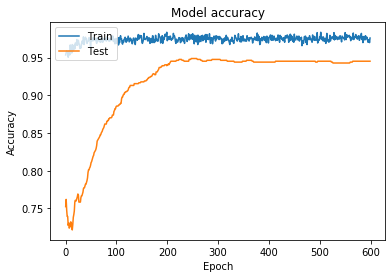

In [88]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [86]:
DD_Net.save_weights('weights/coarse_lite.h5')

## With frame_sampling

In [16]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])

In [ ]:
epochs = 20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 

        label = np.zeros(C.clc_coarse)
        label[Train['coarse_label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,22,3])
        p = sampling_frame(p,C)
        
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )



# Calculate time (excute it twice, the first time initialize takes extra times)

In [ ]:
import time
start_time = time.time()
y = DD_Net.predict([X_0,X_1])
time.time() - start_time

# Plot confusion matrix

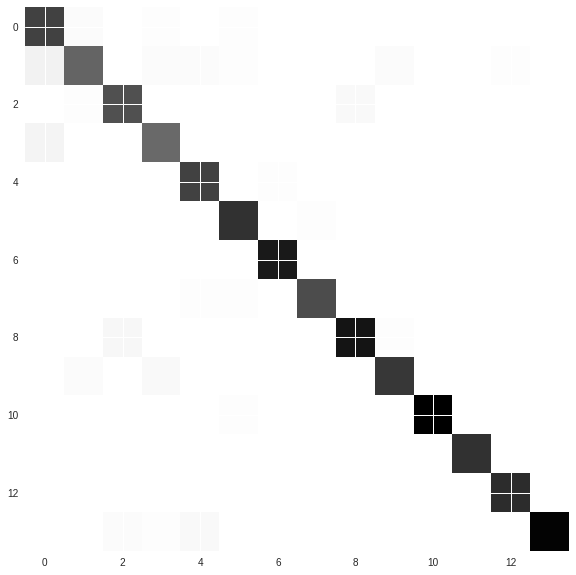

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = DD_Net.predict([X_test_0,X_test_1])
cnf_matrix = confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
plt.figure(figsize=(10,10))
plt.imshow(cnf_matrix)
plt.show()